# Multi-Class Text Classification with scikit learn
by Carlos León

## Introduction


This notebook is an attempt to solve a prediction problem with 'Product' as the label and 'Consumer complaint narrative' as input. To give a quick solution and respectable accuracy, i only use two features and dropped the others.

We will make fast steps of Data Science like data collection, EDA, data cleaning, data preprocessing, data engineering and machine learning to solve this multi-classification problem. 

This dataset is available at https://www.consumerfinance.gov/data-research/consumer-complaints/#download-the-data for consumer-complaint database for the Banking sector. 

### Structure of the dataset
<img src="images/dataset_variables.png" >

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

#from ast import literal_eval
%matplotlib inline

## Data Collection

In [2]:
# Importing the dataset
file = 'Consumer_Complaints.csv'
folder = 'data/'
complaints = pd.read_csv(folder+file)

# How our data looks like
complaints.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,08/09/2015,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company chooses not to provide a public response,Experian Information Solutions Inc.,NJ,08872,NaN,Consent not provided,Web,08/09/2015,Closed with non-monetary relief,Yes,No,1509954
1,12/23/2019,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,NaN,NaN,AES/PHEAA,MA,019XX,NaN,NaN,Web,12/23/2019,Closed with explanation,Yes,NaN,3475943
2,01/29/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"EQUIFAX, INC.",NY,10801,NaN,Consent not provided,Web,01/30/2019,Closed with non-monetary relief,Yes,NaN,3136759
3,08/19/2015,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,Company chooses not to provide a public response,WELLS FARGO & COMPANY,CA,94526,NaN,Consent not provided,Web,08/19/2015,Closed with explanation,Yes,No,1527601
4,03/04/2016,Credit card,NaN,Billing disputes,NaN,I am dissatisfied with the current outcome of ...,NaN,DISCOVER BANK,NV,891XX,NaN,Consent provided,Web,03/04/2016,Closed with explanation,Yes,Yes,1816726


## Data Cleaning

In [3]:
# Number of nan values per column
print('Null values per column')
print('----------------------')
complaints.isna().sum()

Null values per column
----------------------


Date received                         0
Product                               0
Sub-product                      235165
Issue                                 0
Sub-issue                        553940
Consumer complaint narrative     987113
Company public response          919710
Company                               0
State                             24297
ZIP code                         136188
Tags                            1264295
Consumer consent provided?       609000
Submitted via                         0
Date sent to company                  0
Company response to consumer          1
Timely response?                      0
Consumer disputed?               695361
Complaint ID                          0
dtype: int64

In [4]:
# Remove null values
df = complaints.copy()
df.dropna(inplace=True, subset=['Consumer complaint narrative'])
print('Rows before dropping null values:',len(complaints))
print('Rows after dropping null values:',len(df))

# Removing columns with high null values
nan_cols = ['Company public response','Zip code','Tags','Consumer consent provided?']

Rows before dropping null values: 1463841
Rows after dropping null values: 476728


In [5]:
# Convert object column to datetime column
df['date_complaint'] = pd.to_datetime(df['Date received'])
df['year_complaint'] = df['date_complaint'].map(lambda x : x.year)
df['month_complaint'] = df['date_complaint'].map(lambda x : x.month)

# Correct some data. Force US state abbreviation
df.loc[df['State']=='UNITED STATES MINOR OUTLYING ISLANDS','State'] = 'UM'

In [6]:
# Reeplacing long product term by a short one
str_filter = "Credit reporting, credit repair services, or other personal consumer reports"
df.loc[df['Product'] == str_filter,'Product'] = 'Other Personal Consumer Reports'

## EDA

Text(0.5, 1, 'Complaints by Year')

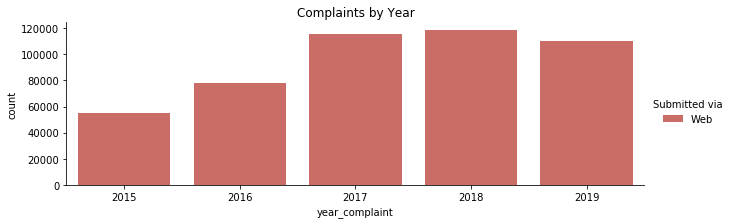

In [7]:
# Complaints by year 
sns.set_palette('hls')
sns.catplot(x='year_complaint', hue='Submitted via', data=df, kind='count', aspect=3, 
                    height=3)
plt.title('Complaints by Year')

Text(0.5, 1, 'Complaints by Product')

<Figure size 1440x720 with 0 Axes>

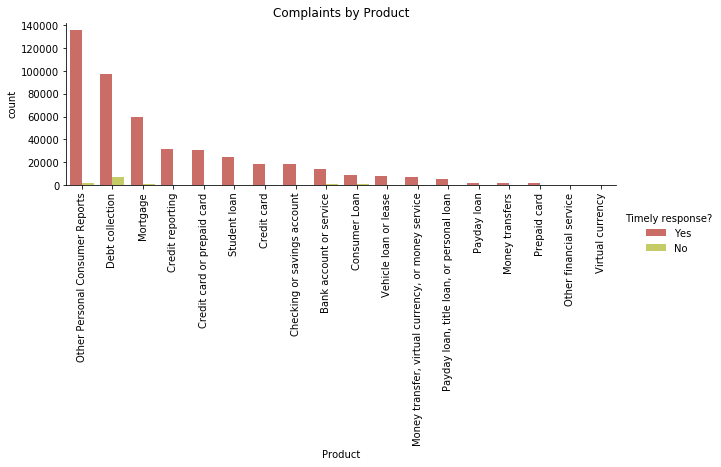

In [8]:
# Complaints by Product

plt.figure(figsize=(20,10))
sns.catplot(x='Product', hue='Timely response?', data=df, kind='count', aspect=3, 
            height=3, order=df['Product'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Complaints by Product')

Text(0.5, 1, 'Complaints by State in USA (First thirty)')

<Figure size 864x576 with 0 Axes>

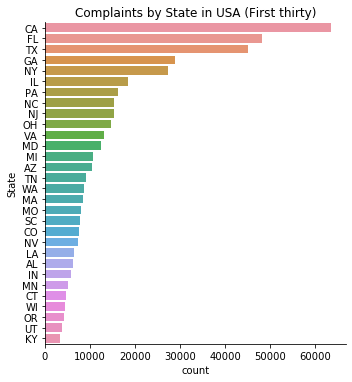

In [9]:
# Complaints by State, the first thirty

plt.figure(figsize=(12,8))
sns.catplot(y='State', data=df, kind='count', order=df['State'].value_counts()[:30].index)
plt.title('Complaints by State in USA (First thirty)')

## Data Preprocessing



### Doing some Text Representation
Text documents are noisy so we need some "word" cleaning 

In [10]:
# Optional: The clean dataframe has 470k rows, we select 100k rows randomly to make  
# calculations faster
k=20000
import random
rand_list = random.choices(df.index, k=k)
df = df.loc[rand_list]

In [11]:
# Select the columns to work with
cols  = ['Product', 'Consumer complaint narrative']

df = df[cols]

# Convert the labels into numbers from 0 to 17
df['category_id'] = df['Product'].factorize()[0]

# Constructing dict for lines bellow
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [12]:
df.head()

,Product,Consumer complaint narrative,category_id
762683,Debt collection,This company has violated state laws and disre...,0
823736,Debt collection,A debt with XXXX XXXX from 2013 was discharged...,0
164023,Debt collection,My husband died on XXXX/XXXX/16. He does not h...,0
922306,Other Personal Consumer Reports,"I contacted XXXX, Equifax and XXXX and asked ...",1
299172,Debt collection,I lived in an Apartment Complex from XX/XX/XXX...,0


In [13]:
# Omit these lines because the lines below take it

# Convert the complaint narrative column to lower case
#df['in_process_narrative'] = df['Consumer complaint narrative'].str.lower()

# Remove Punctuations
#df['in_process_narrative'] = df['in_process_narrative'].str.replace('[^\w\s]','')

# Tokenize the complaint narrative
#df['in_process_narrative'] = df['in_process_narrative'].apply(word_tokenize)

# Remove Stopwords
#stop_words = stopwords.words('english')
#df['in_process_narrative'] = df['in_process_narrative'].apply(lambda x: [word for word in x 
#                                                                          if word not in stop_words])
# Do some lemmatization for example "troubling" would map to "trouble"
#wordnet = WordNetLemmatizer()
#df['cleaned_narrative'] = df['in_process_narrative'].apply(lambda tokens: [wordnet.lemmatize(token) for token in tokens])


In [14]:
# Convert each complaint narrative into vectors. Also removes stopwords
import sklearn 
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', 
                        ngram_range=(1,2), stop_words='english')

features = tfidf.fit_transform(df['Consumer complaint narrative']).toarray()
labels = df['category_id']
features.shape

(20000, 53313)

In [15]:
# Looking for the most correlated terms using chi2
from sklearn.feature_selection import chi2

N = 2
for Product, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bank account or service':
  . Most correlated unigrams:
. bank
. overdraft
  . Most correlated bigrams:
. overdraft fees
. checking account
# 'Checking or savings account':
  . Most correlated unigrams:
. bonus
. deposit
  . Most correlated bigrams:
. direct deposit
. checking account
# 'Consumer Loan':
  . Most correlated unigrams:
. car
. vehicle
  . Most correlated bigrams:
. vehicle loan
. drive time
# 'Credit card':
  . Most correlated unigrams:
. macy
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit card or prepaid card':
  . Most correlated unigrams:
. rewards
. card
  . Most correlated bigrams:
. american express
. credit card
# 'Credit reporting':
  . Most correlated unigrams:
. experian
. equifax
  . Most correlated bigrams:
. file used
. accounts section
# 'Debt collection':
  . Most correlated unigrams:
. collection
. debt
  . Most correlated bigrams:
. collection agency
. collect debt
# 'Money transfer, virtual currency, or money service':


### Multiclass Classifier : Features and Design
Vector of words need to be transformed into vector of numbers and then into TF-IDF weighted 
vectors before feeding the classifier

In [17]:
# Setting the train and test data.
# Convert vectors into TF-IDF weighted vectors and use a classifier to predict the category of 
# a complaint

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Consumer complaint narrative'], 
                                                    df['Product'], test_size=0.2, 
                                                    random_state=42)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

classifier = MultinomialNB().fit(X_train_tfidf, y_train)
complaint = "This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."
print('The prediction of this complaint is :', classifier.predict(count_vect.transform([complaint])))

The prediction of this complaint is : ['Debt collection']


### Model Selection
In general we need to compare between different classification models to select the model with best accuracy. But to simplify the process, we will select the **Linear Support Vector Machine**, because is known that it has great performance.

### Model Evaluation
Continuing with our best model (LinearSVC), we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels.

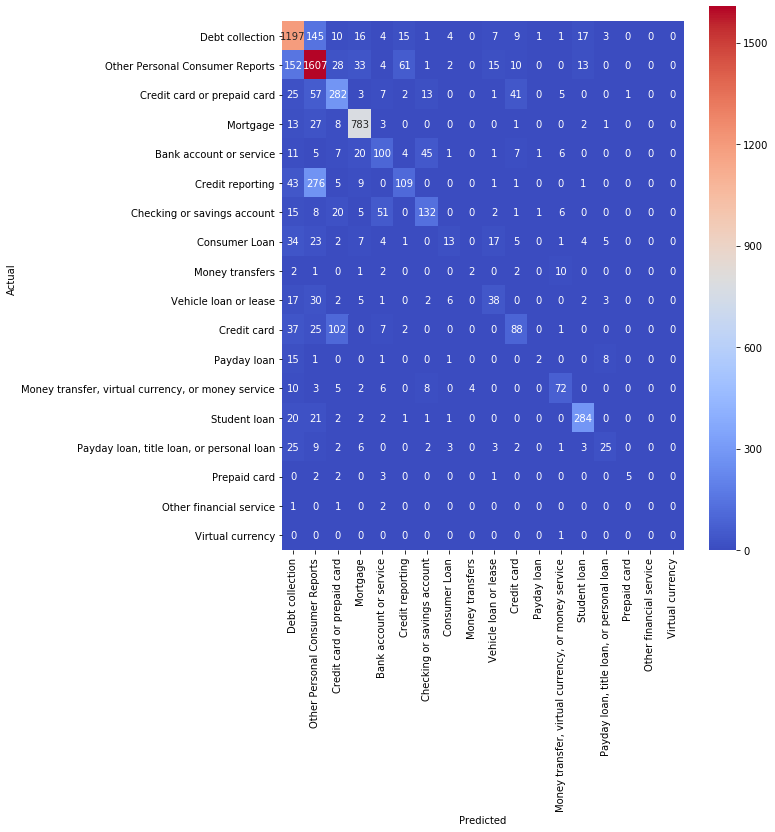

In [18]:
# Plotting the confusion matrix in a heatmap
# As you see there are some missclassified complaints but these errors will happen. 

from sklearn.svm import LinearSVC

model = LinearSVC()
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, 
                                                    random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(9,10))

sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values,cmap="coolwarm")
ax.set_ylim(len(conf_mat), -0.5)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [19]:
# Again Use chi-squared test to find the terms that are the most correlated with each of the
# categories. Check the consistency

model.fit(features, labels)
N = 2
for Product, category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("# '{}':".format(Product))
    print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
    print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Bank account or service':
  . Top unigrams:
       . bank
       . citigold
  . Top bigrams:
       . opened checking
       . xx 2016
# 'Checking or savings account':
  . Top unigrams:
       . bank
       . account
  . Top bigrams:
       . debit card
       . charge overdraft
# 'Consumer Loan':
  . Top unigrams:
       . car
       . conn
  . Top bigrams:
       . drive time
       . leaving message
# 'Credit card':
  . Top unigrams:
       . macy
       . card
  . Top bigrams:
       . credit card
       . credit line
# 'Credit card or prepaid card':
  . Top unigrams:
       . card
       . netspend
  . Top bigrams:
       . received card
       . payment activity
# 'Credit reporting':
  . Top unigrams:
       . equifax
       . experian
  . Top bigrams:
       . xxxx bureaus
       . xxxx inquiries
# 'Debt collection':
  . Top unigrams:
       . debt
       . collection
  . Top bigrams:
       . account delete
       . ftc id
# 'Money transfer, virtual currency, or money servic

In [20]:
# Print out the classification report

from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Product'].unique()))

                                                    precision    recall  f1-score   support

                                   Debt collection       0.74      0.84      0.79      1430
                   Other Personal Consumer Reports       0.72      0.83      0.77      1926
                       Credit card or prepaid card       0.59      0.65      0.62       437
                                          Mortgage       0.88      0.93      0.91       838
                           Bank account or service       0.51      0.48      0.49       208
                                  Credit reporting       0.56      0.24      0.34       445
                       Checking or savings account       0.64      0.55      0.59       241
                                     Consumer Loan       0.42      0.11      0.18       116
                                   Money transfers       0.33      0.10      0.15        20
                             Vehicle loan or lease       0.44      0.36      0.

/Users/carlosalbertoleonliza/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
